In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("./GENEdata.csv")

In [3]:
df = df.drop("Unnamed: 0", axis = 1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 16352 entries, gene_4773 to gene_14160
dtypes: float64(16335), int64(17)
memory usage: 99.9 MB


# Visualization (t-SNE)

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

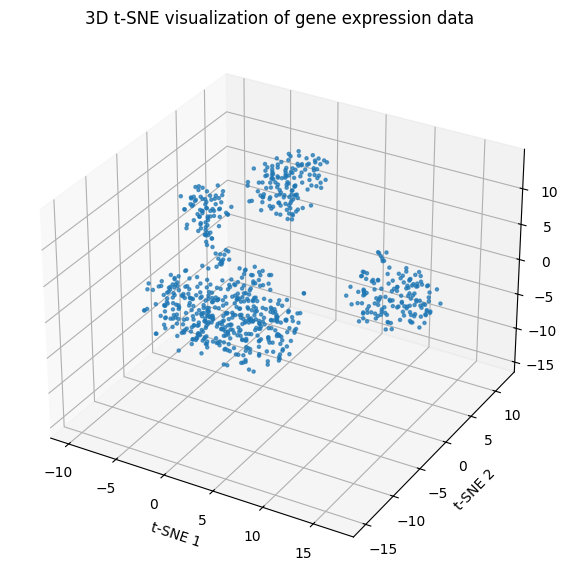

In [6]:
# Apply t-SNE for visualization purposes
tsne = TSNE(n_components=3, random_state=42)
data_tsne_3d = tsne.fit_transform(df)

# Create a DataFrame with the t-SNE results
tsne_df_3d = pd.DataFrame(data_tsne_3d, columns=['t-SNE 1', 't-SNE 2', 't-SNE 3'])

# Plot the t-SNE results
# Plot the t-SNE results in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_df_3d['t-SNE 1'], tsne_df_3d['t-SNE 2'], tsne_df_3d['t-SNE 3'], s=5, alpha=0.7)
ax.set_title('3D t-SNE visualization of gene expression data')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
plt.show()

# Feature Selection

In [7]:
from sklearn.feature_selection import VarianceThreshold

# Set a threshold to remove low-variance features
threshold = 0.12 #vary between 0.07 - 0.12 observe results
selector = VarianceThreshold(threshold=threshold)
data_high_variance = selector.fit_transform(df)

# Get the indices of the selected features
selected_features = selector.get_support(indices=True)
selected_feature_names = df.columns[selected_features]

# Print the selected feature names
print("Selected Features:", selected_feature_names)

Selected Features: Index(['gene_4773', 'gene_8891', 'gene_15301', 'gene_4617', 'gene_5453',
       'gene_11920', 'gene_742'],
      dtype='object')


# Clustering

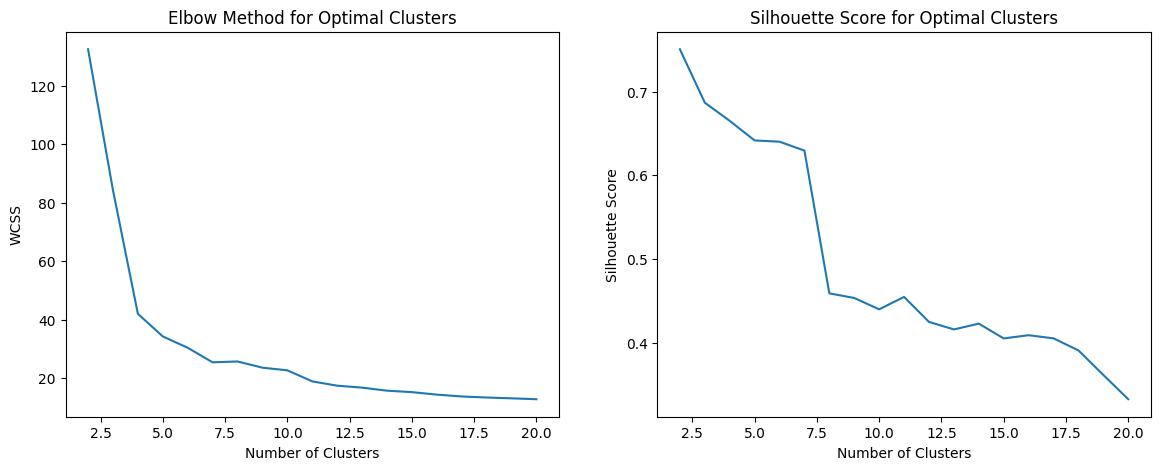

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Determine the optimal number of clusters
wcss = []
silhouette_scores = []
range_n_clusters = range(2, 21)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data_high_variance)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_high_variance, cluster_labels))

# Plot WCSS and silhouette scores to determine the optimal number of clusters
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Clusters')

plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Clusters')
plt.show()

In [11]:
optimal_clusters = 6

# Perform clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(data_high_variance)

# Add cluster labels to the original data for further analysis
df['cluster'] = clusters

# Data Visualization - Understanding the results

In [11]:
import numpy as np
from scipy import stats
import seaborn as sns

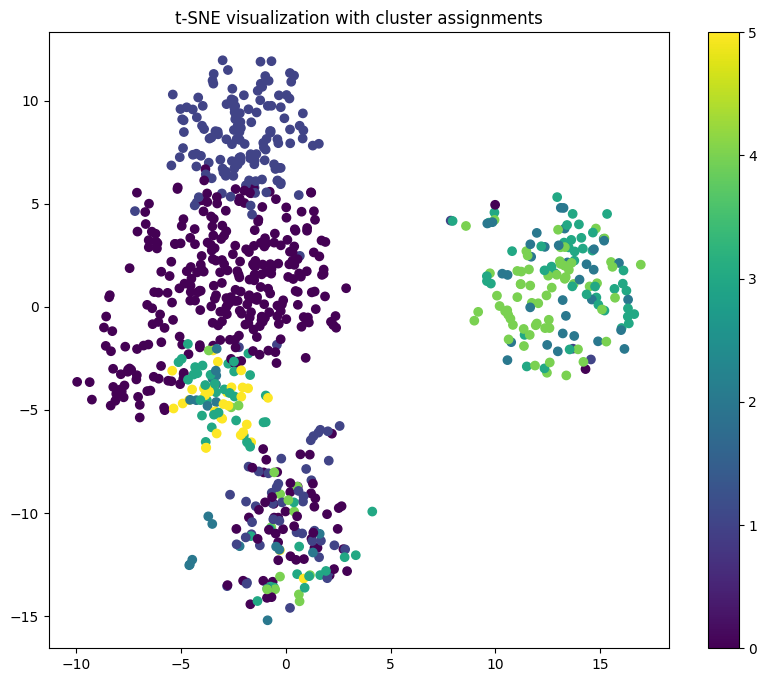

In [12]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data_tsne_3d[:, 0], data_tsne_3d[:, 1], c=clusters, cmap='viridis')
plt.colorbar(scatter)
plt.title('t-SNE visualization with cluster assignments')
plt.show()

In [13]:
# Function to find top differentiating genes
def top_differentiating_genes(data, clusters, n_top=20):
    p_values = []
    for gene in range(data.shape[1]):
        f_value, p_value = stats.f_oneway(*[data[clusters == i, gene] for i in np.unique(clusters)])
        p_values.append(p_value)
    top_genes = np.argsort(p_values)[:n_top]
    return top_genes

top_genes = top_differentiating_genes(data_high_variance, clusters)

In [14]:
top_genes

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

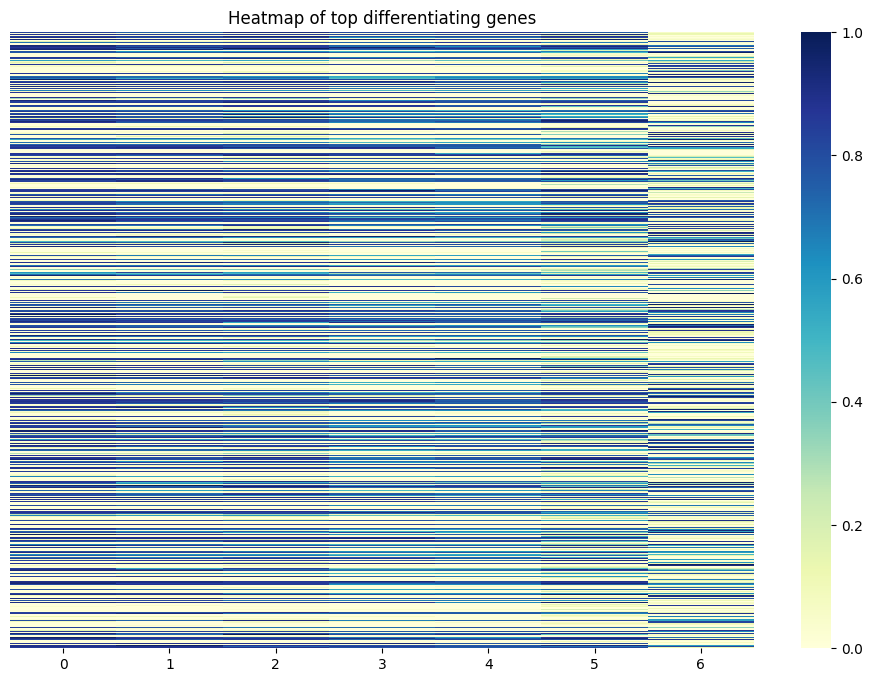

In [15]:
plt.figure(figsize=(12, 8))
sns.heatmap(data_high_variance[:, top_genes], cmap='YlGnBu', yticklabels=False)
plt.title('Heatmap of top differentiating genes')
plt.savefig('filename.png', format='png', transparent=True)
plt.show()

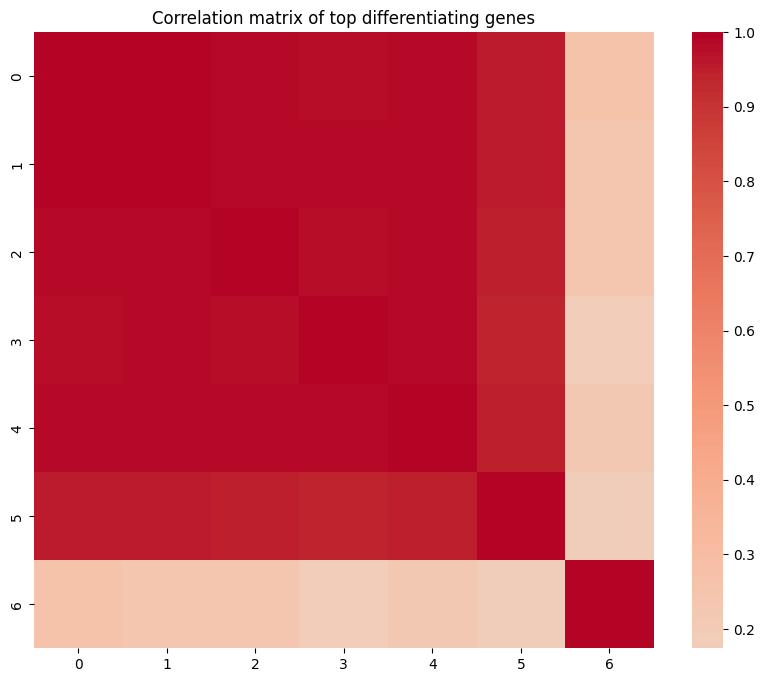

In [16]:
corr_matrix = np.corrcoef(data_high_variance[:, top_genes].T)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation matrix of top differentiating genes')
plt.show()

note: could not interpret much from these...moving on with my approach

# Identifying Dominant Features of each cluster

* For each cluster, we can calculate the average expression of each gene.
* We can then compare these averages to the overall average expression across all clusters.
* The genes with the highest difference from the overall average could be considered the dominant or differentiating features for that cluster.

In [13]:
# Calculate overall mean expression for each gene
overall_mean = df.drop('cluster', axis=1).mean()

# Function to get top differentiating genes for a cluster
def get_top_genes(cluster_data, overall_mean, n=10):
    cluster_mean = cluster_data.mean()
    diff = cluster_mean - overall_mean
    top_over = diff.nlargest(n)
    top_under = diff.nsmallest(n)
    return pd.concat([top_over, top_under], keys=['Over-expressed', 'Under-expressed'])

In [14]:
# Get top differentiating genes for each cluster
top_genes_by_cluster = {}
for cluster in df['cluster'].unique():
    cluster_data = df[df['cluster'] == cluster].drop('cluster', axis=1)
    top_genes_by_cluster[cluster] = get_top_genes(cluster_data, overall_mean)

In [15]:
for cluster, genes in top_genes_by_cluster.items():
    print(f"\nTop differentiating genes for Cluster {cluster}:")
    print(genes)


Top differentiating genes for Cluster 1:
Over-expressed   gene_4617     0.475652
                 gene_8891     0.474496
                 gene_9175     0.474371
                 gene_4773     0.469027
                 gene_15301    0.464652
                 gene_9176     0.455694
                 gene_13976    0.438944
                 gene_5453     0.433578
                 gene_11920    0.429677
                 gene_4618     0.428466
Under-expressed  gene_8024    -0.303711
                 gene_8031    -0.264881
                 gene_2831    -0.256916
                 gene_8032    -0.256529
                 gene_13217   -0.245687
                 gene_10266   -0.227884
                 gene_742     -0.223514
                 gene_6836    -0.220433
                 gene_2844    -0.219110
                 gene_9831    -0.212556
dtype: float64

Top differentiating genes for Cluster 0:
Over-expressed   gene_9652     0.251486
                 gene_15589    0.237269
                 gene

 ### Visualization of Clusters and their dominant features - Validating Clustering Results 

In [16]:
# 1. Prepare data for visualization
def prepare_data_for_viz(top_genes_by_cluster, df, n_top=5):
    all_top_genes = set()
    for genes in top_genes_by_cluster.values():
        all_top_genes.update(genes['Over-expressed'].index[:n_top])
        all_top_genes.update(genes['Under-expressed'].index[:n_top])
    
    viz_data = df[list(all_top_genes) + ['cluster']]
    return viz_data

viz_data = prepare_data_for_viz(top_genes_by_cluster, df)

In [17]:
# 2. Create a heatmap
plt.figure(figsize=(15, 10))

# Prepare data for heatmap
heatmap_data = viz_data.groupby('cluster')[viz_data.columns[:-1]].mean()

# Create heatmap
sns.heatmap(heatmap_data, cmap='YlGnBu', center=0, annot=False)
plt.title('Heatmap of Top Differentiating Genes Across Clusters')
plt.xlabel('Genes')
plt.ylabel('Clusters')
plt.tight_layout()
plt.show()

NameError: name 'sns' is not defined

<Figure size 1500x1000 with 0 Axes>

In [ ]:
# 3. Create bar plots
n_clusters = len(top_genes_by_cluster)
fig, axes = plt.subplots(n_clusters, 1, figsize=(15, 5*n_clusters), sharex=True)
fig.suptitle('Top 5 Over-expressed and Under-expressed Genes by Cluster', fontsize=16)

for i, (cluster, genes) in enumerate(top_genes_by_cluster.items()):
    top_over = genes['Over-expressed'][:5]
    top_under = genes['Under-expressed'][:5]
    
    combined = pd.concat([top_over, top_under])
    colors = ['green']*5 + ['red']*5
    
    axes[i].bar(combined.index, combined.values, color=colors)
    axes[i].set_title(f'Cluster {cluster}')
    axes[i].set_ylabel('Expression Difference')
    axes[i].axhline(y=0, color='k', linestyle='--')
    
    # Rotate x-axis labels for better readability
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

cluster_labels = kmeans.labels_

# Compute silhouette score
silhouette_avg = silhouette_score(data_high_variance, cluster_labels)

print(f"Silhouette Score for Clustering: {silhouette_avg}")

# Side Tracking - Gene Ontology

In [ ]:
!pip install goatools

In [ ]:
from goatools import obo_parser
from goatools.go_enrichment import GOEnrichmentStudy
from goatools.anno.genetogo_reader import Gene2GoReader

In [ ]:
import requests
from urllib.parse import urljoin

In [ ]:
url = "https://current.geneontology.org/ontology/go-basic.obo"
filename = "go-basic.obo"  # Specify the desired filename

response = requests.get(url)

# Check for successful download
if response.status_code == 200:
    with open(filename, 'wb') as f:
        f.write(response.content)
    print(f"Downloaded file: {filename}")
else:
    print(f"Error downloading file: {response.status_code}")
    # Handle potential errors (e.g., raise exception, exit gracefully)

In [ ]:
# Load GO terms
go_obo = "go-basic.obo"
go = obo_parser.GODag(go_obo)

# Load gene associations (using recommended method)
gene2go_reader = Gene2GoReader(go)  # Initialize reader with GO DAG
associations = gene2go_reader.read("gene2go", taxids=[9606])  # Read associations for human (taxid 9606)

In [ ]:
# Perform GO enrichment for each cluster
for cluster, genes in top_genes_by_cluster.items():
    study_genes = set(genes['Over-expressed'].index) | set(genes['Under-expressed'].index)
    population = set(df.columns) - {'cluster'}
    
    g = GOEnrichmentStudy(population, associations, go, propagate_counts=False, alpha=0.05)
    g_results = g.run_study(study_genes)
    
    print(f"\nGO Enrichment Results for Cluster {cluster}:")
    for r in g_results[:10]:  # Print top 10 results
        print(f"{r.GO} {r.name} {r.p_uncorrected:.3e}")

# Going back to primary objective

* We already have the 6 clusters and the dominant features identifying each cluster

## Exploring Relationships using Neural Nets (Dominant Features - minor features)

#### Overview
- Build a neural network:
- Use dominant features as input neurons.
- Use minor features as hidden layers.
- The output layer should predict the cluster.
- Train the neural network and analyze the weights to understand the relationship between dominant and minor features.

**Step 1: Prepare Data for Neural Network -  Identify Dominant and Minor Features:**
* Use the selected_feature_names obtained from the earlier feature selection step (VarianceThreshold). These are dominant features.
* Define minor features as the remaining features that were not selected by VarianceThreshold.
* Extract the dominant features (data_high_variance) and the cluster labels (clusters) from your DataFrame df.

**Step 2: Build and Train the Neural Network**
* Use a framework like TensorFlow or PyTorch to define your neural network.
* Input layer: Number of neurons equal to the number of dominant features.
* Hidden layers: Design these layers based on the number and complexity of your minor features.
* Output layer: One neuron for predicting the cluster label (multi-class classification).

*Train the network using appropriate loss function (e.g., categorical cross-entropy for multi-class classification) and optimizer (e.g., Adam optimizer).*

*Monitor training progress using validation metrics such as accuracy.*


**Step 3: Analyze Neural Network Weights - Interpretation of Weights:**

* After training, analyze the weights of the neural network to understand which dominant features (input neurons) contribute most significantly to predicting each cluster (output layer).
* Investigate how the minor features (hidden layers) interact with the dominant features and contribute to the final prediction.

In [24]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [25]:

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data_high_variance, clusters, test_size=0.2, random_state=42)

# Build neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16345, activation='relu', input_shape=(data_high_variance.shape[1],)),
    # tf.keras.layers.Dense(64, activation='relu', input_shape=(data_high_variance.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(optimal_clusters, activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # For integer-encoded labels
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Evaluate model
loss, accuracy = model.evaluate(X_val, y_val)

Epoch 1/50


C:\Users\MSI 1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6368 - loss: 1.4172 - val_accuracy: 0.8012 - val_loss: 0.5080
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8264 - loss: 0.3992 - val_accuracy: 0.8634 - val_loss: 0.3383
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9276 - loss: 0.3074 - val_accuracy: 0.9068 - val_loss: 0.2988
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9269 - loss: 0.2664 - val_accuracy: 0.9068 - val_loss: 0.2562
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9346 - loss: 0.2290 - val_accuracy: 0.9006 - val_loss: 0.2286
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9348 - loss: 0.2173 - val_accuracy: 0.9068 - val_loss: 0.2111
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9355 - loss: 0.1869 - val_accuracy: 0.9255 - val_loss: 0.1756
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9380 - loss: 0.1620 - val_accuracy: 0.9130 - val_loss: 0.1683
Ep

In [26]:
layer_weights = model.layers[0].get_weights()[0]  # Get weights of the first layer
print("Weights of the first layer:", layer_weights)

Weights of the first layer: [[ 4.4619632e-05  4.5083994e-03 -5.3671557e-03 ...  7.5211609e-04
  -1.8423291e-02  1.0484675e-02]
 [ 2.1259502e-02  1.8897491e-02 -2.4911223e-03 ...  1.2215385e-02
  -2.6451802e-02 -5.8166934e-03]
 [ 2.1365242e-02  1.6120397e-02 -3.8763374e-02 ...  9.5605850e-03
   6.6595273e-03 -5.0352970e-03]
 ...
 [ 4.3026920e-02  3.3824656e-02 -2.0711670e-02 ...  4.3555065e-03
  -4.7788922e-02 -1.6985124e-02]
 [ 4.4841629e-02 -4.2503979e-02  6.3478112e-02 ... -1.5390873e-02
  -5.1519042e-04 -3.4408759e-02]
 [ 4.2726506e-02 -9.5188124e-03 -1.2599725e-02 ... -8.4055789e-02
   6.5590935e-03  6.5455310e-02]]


## Cytoscape - Extracting Relationships

In [27]:
# relationship_df = pd.DataFrame(layer_weights, index=dominant_features, columns=minor_features)

In [28]:
# Get the weights of the first layer (dominant features to hidden layer)
dominant_to_hidden_weights = model.layers[0].get_weights()[0]

# Get the weights of the second layer (hidden layer to output layer)
hidden_to_output_weights = model.layers[1].get_weights()[0]

In [33]:
# Print or analyze these weights to understand the relationships
# print("Weights from dominant features to hidden layer:\n", dominant_to_hidden_weights)
# print("Weights from hidden layer to output layer:\n", hidden_to_output_weights)

In [18]:
dominant_features = selected_feature_names.tolist() 

# All features in the original dataset
all_features = df.drop("cluster", axis = 1).columns.tolist()

# Minor features are those not in dominant_features
minor_features = [feature for feature in all_features if feature not in dominant_features]

print("Dominant Features:", dominant_features)
print("Minor Features:", minor_features[: 10])

Dominant Features: ['gene_4773', 'gene_8891', 'gene_15301', 'gene_4617', 'gene_5453', 'gene_11920', 'gene_742']
Minor Features: ['gene_7964', 'gene_4618', 'gene_3921', 'gene_13831', 'gene_13976', 'gene_8005', 'gene_7965', 'gene_1858', 'gene_9175', 'gene_8024']


In [19]:
relationship_df = pd.DataFrame(layer_weights, index=dominant_features, columns=minor_features)

NameError: name 'layer_weights' is not defined

In [20]:
# Node File
nodes = set(dominant_features).union(set(minor_features))

# Create a DataFrame for the nodes
node_df = pd.DataFrame(list(nodes), columns=['gene'])
# Add a placeholder column, e.g., 'type' with default value 'gene'
node_df['type'] = 'gene'

node_df.to_csv('nodes.csv', index=False)

In [35]:
edges = []
for dominant in dominant_features:
    for minor in minor_features:
        weight = relationship_df.loc[dominant, minor]
        edges.append([dominant, minor, weight])

edge_df = pd.DataFrame(edges, columns=['source', 'target', 'weight'])
edge_df.to_csv('edges.csv', index=False)